<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# Training and Evaluating Static Heatmap Regression Model for Multi-Instance and Single-Class Landmark Detetection (Plant Centroids)

TODO

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the UNet model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/static_unet_plant_centroids.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [2]:
!python -c "import landmarker" || pip install landmarker

## Setup imports and variables

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from monai.transforms import (Compose, RandAffined, RandGaussianNoised, RandStdShiftIntensityd,
                              RandScaleIntensityd, RandAdjustContrastd, RandHistogramShiftd)
from tqdm import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

In [5]:
fn_keys = ('image',)
spatial_transformd = [RandAffined(fn_keys, prob=1,
                        rotate_range=(-np.pi/12, np.pi/12),
                        translate_range=(-10, 10),
                        scale_range=(-0.1, 0.1),
                        shear_range=(-0.1, 0.1)
                        )]

composed_transformd = Compose(spatial_transformd)

In [6]:
from landmarker.heatmap.generator import GaussianHeatmapGenerator
from landmarker.datasets import get_plant_centroids_landmark_datasets

ds_train, ds_test_A, ds_test_B, ds_test_C = get_plant_centroids_landmark_datasets("data", transform = composed_transformd, grayscale=False, store_imgs=False,
                                                                                 dim_img=(512,512))

100%|██████████| 234/234 [00:00<00:00, 5655.99it/s]


Reading and extracting masks from 1398 images...


100%|██████████| 1398/1398 [00:04<00:00, 326.38it/s]


Reading and extracting masks from 100 images...


100%|██████████| 100/100 [00:00<00:00, 349.23it/s]


Reading and extracting masks from 275 images...


100%|██████████| 275/275 [00:00<00:00, 342.59it/s]


Reading and extracting masks from 234 images...


100%|██████████| 234/234 [00:00<00:00, 335.88it/s]


## Constructing a heatmap generator

In [7]:
from landmarker.heatmap.generator import GaussianHeatmapGenerator

heatmap_generator = GaussianHeatmapGenerator(
    nb_landmarks=1,
    sigmas=3,
    gamma=None,
    heatmap_size=(512, 512),
    learnable=False, # If True, the heatmap generator will be trainable
    device=device
)

## Inspecting the dataset

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data (

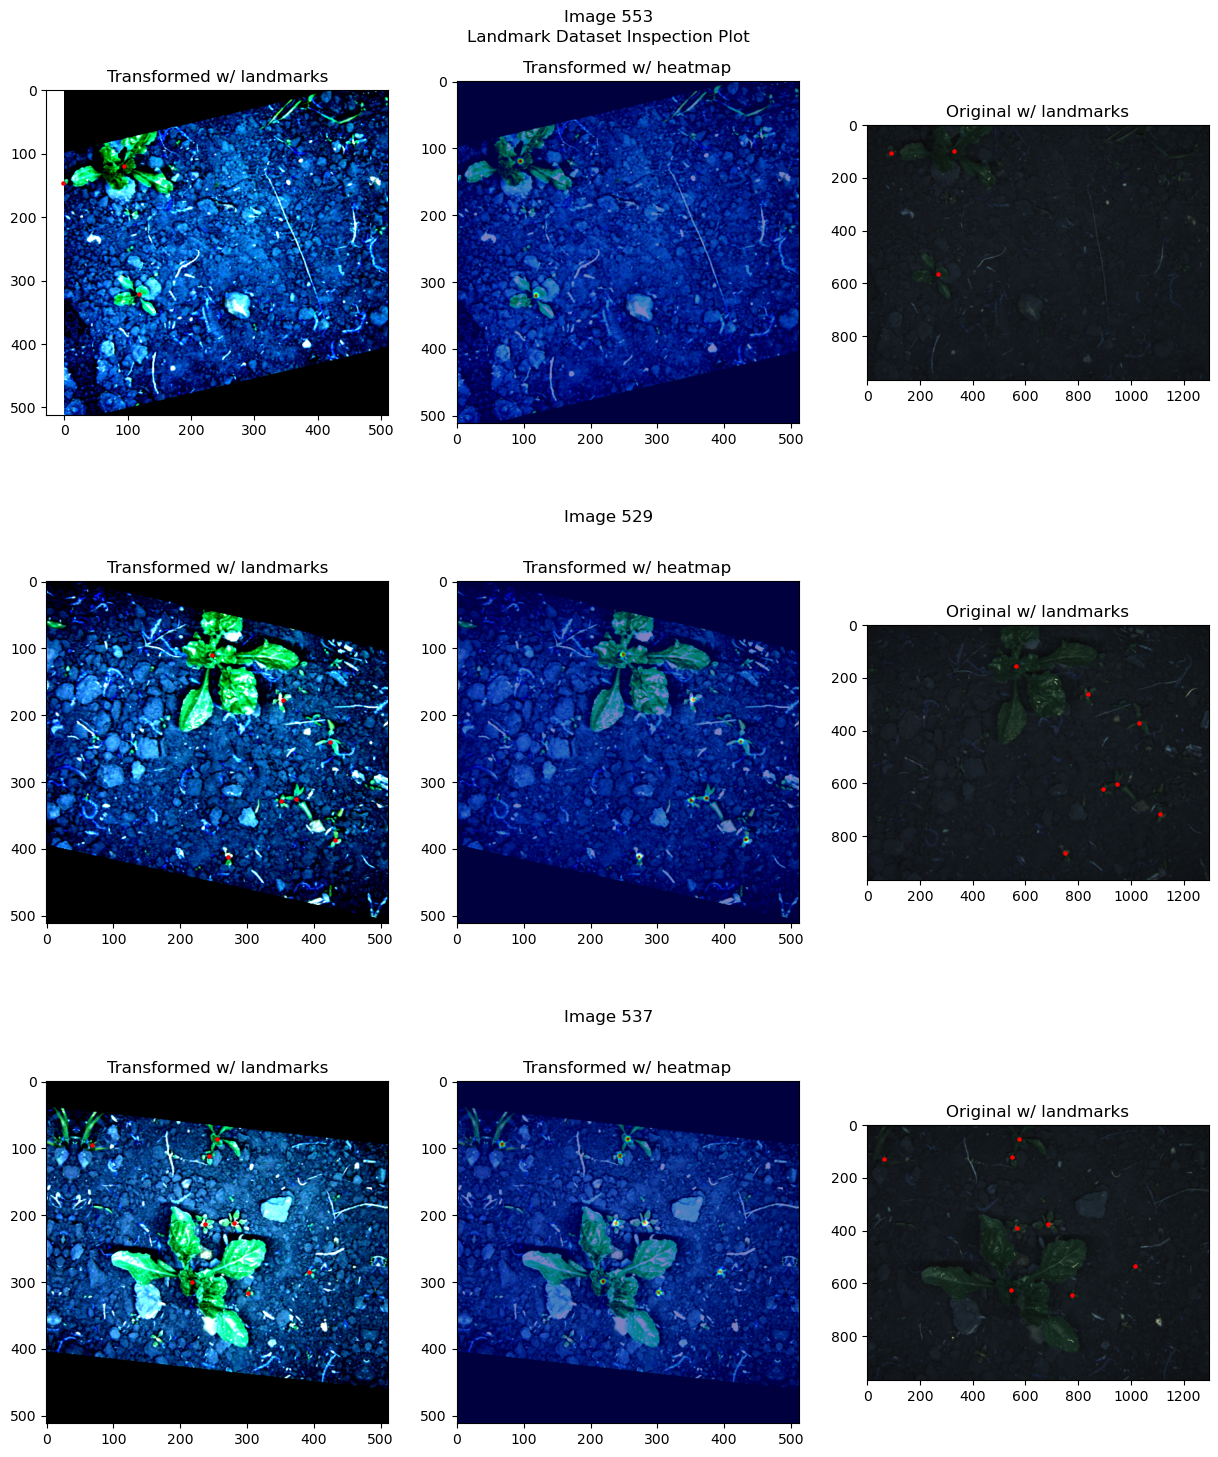

In [8]:
from landmarker.visualize import inspection_plot

# Plot the first 3 images from the training set
heatmap_generator.device = "cpu" # because dataset tensors are still on cpu
inspection_plot(ds_train, np.random.randint(0, len(ds_train), 3),
               heatmap_generator)
heatmap_generator.device = device # set the desired device back

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


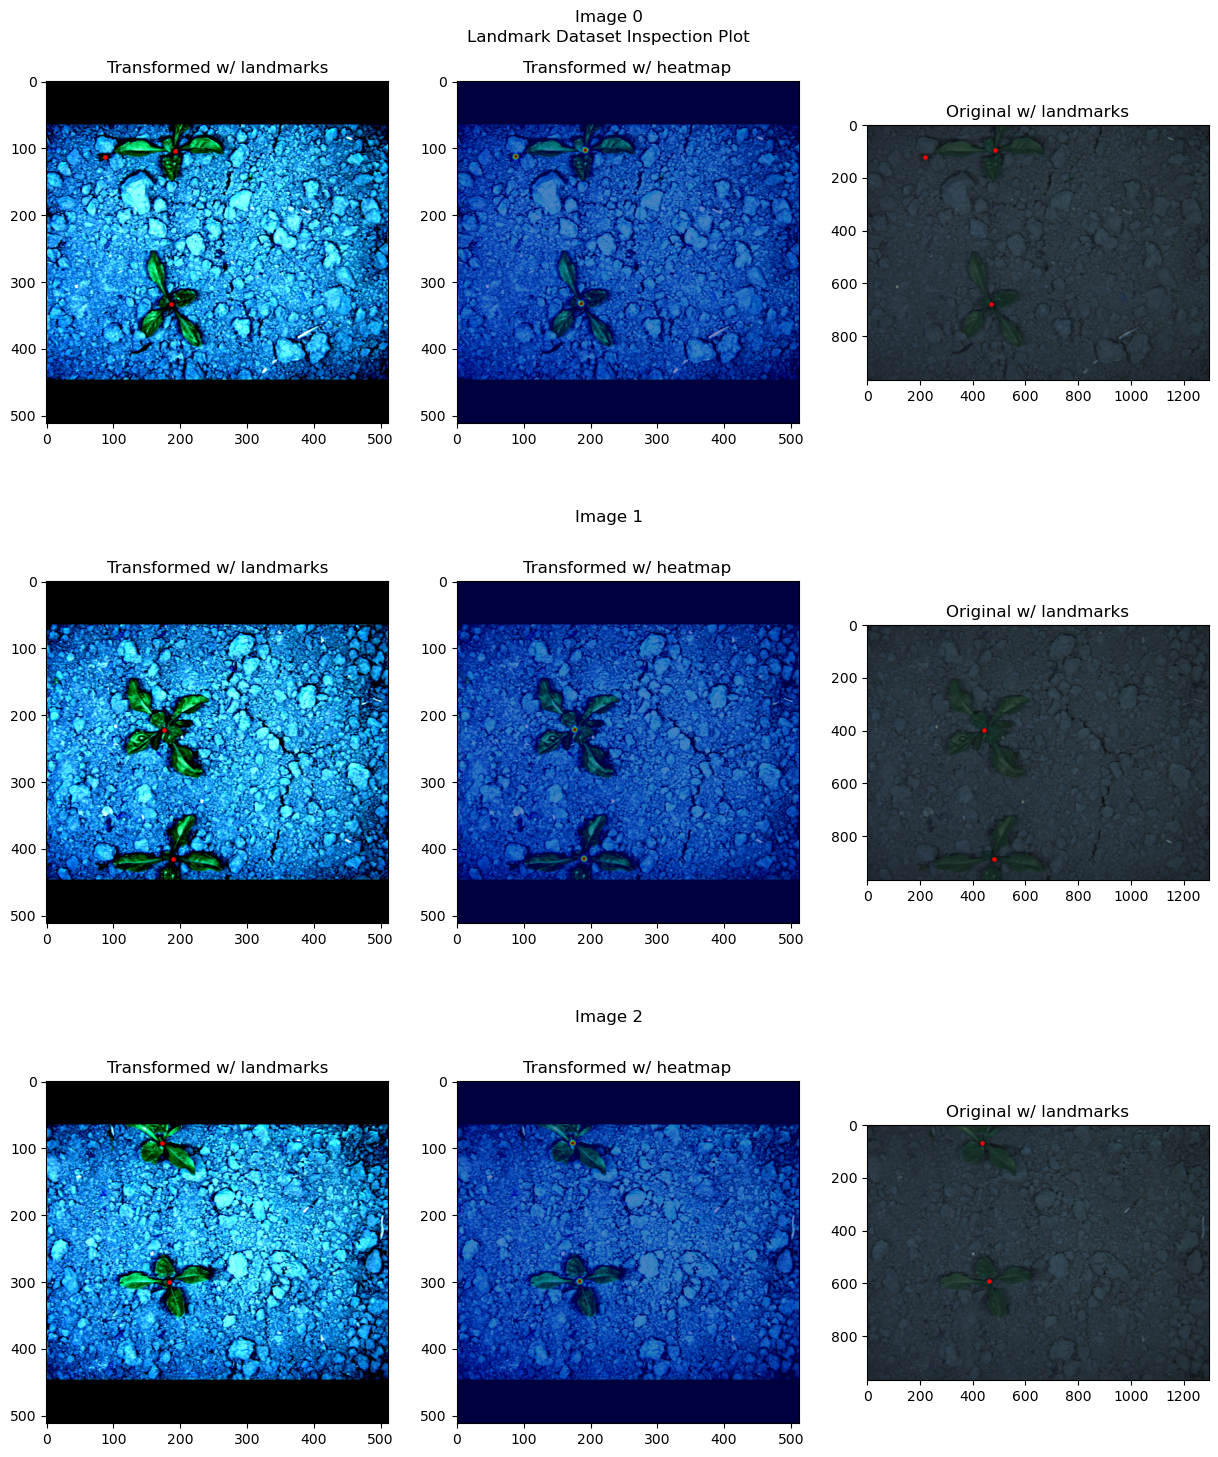

In [9]:
# Plot the first 3 images from the test1 set
heatmap_generator.device = "cpu" # because dataset tensors are still on cpu
inspection_plot(ds_test_A, range(3), heatmap_generator)
heatmap_generator.device = device # set the desired device back

## Training and initializing the SpatialConfiguration model

### Initializing the model, optimizer and loss function

In [10]:
from torch import nn

from landmarker.models import get_model
from landmarker.train import EarlyStopping, SaveBestModel

model = get_model("UNet", in_channels=4, out_channels=1).to(device)

lr = 1e-4
batch_size = 4
epochs = 1000

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

criterion = nn.BCEWithLogitsLoss()

early_stopping = EarlyStopping(patience=10, verbose=True)
save_best_model = SaveBestModel(verbose=True)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                          patience=20, verbose=True, cooldown=10)

### Setting the data loaders and split training set

In [11]:
split_lengths = [0.8, 0.2]
ds_train_train, ds_train_val = torch.utils.data.random_split(ds_train, split_lengths)
train_loader = DataLoader(ds_train_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(ds_train_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_A_loader = DataLoader(ds_test_A, batch_size=batch_size, shuffle=False, num_workers=0)
test_B_loader = DataLoader(ds_test_B, batch_size=batch_size, shuffle=False, num_workers=0)
test_C_loader = DataLoader(ds_test_C, batch_size=batch_size, shuffle=False, num_workers=0)

### Training the model

In [12]:
from landmarker.heatmap.decoder import heatmap_to_coord, heatmap_to_multiple_coord
from landmarker.metrics import point_error

from torch.nn.functional import sigmoid

from landmarker.metrics.metrics import multi_instance_point_error

def train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, (images, landmarks, _, _, _, _, _, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        landmarks = landmarks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        heatmaps = heatmap_generator(landmarks)
        loss = criterion(outputs, heatmaps)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, heatmap_generator, val_loader, criterion, device):
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for _, (images, landmarks, _, _, _ , _, _,
                _) in enumerate(tqdm(val_loader)):
            images = images.to(device)
            landmarks = landmarks.to(device)
            outputs = model(images)
            heatmaps = heatmap_generator(landmarks)
            loss = criterion(outputs, heatmaps)
            eval_loss += loss.item()
    return eval_loss / len(val_loader)

def train(model, heatmap_generator, train_loader, val_loader, criterion, optimizer, device, epochs=1000):
    for epoch in range(epochs):
        ds_train.transform = composed_transformd
        train_loss = train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device)
        ds_train.transform = None
        val_loss = val_epoch(model, heatmap_generator, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}")
        early_stopping(val_loss)
        save_best_model(val_loss, model)
        lr_scheduler.step(val_loss)
        if early_stopping.early_stop:
            print(f"Loading best model...")
            model.load_state_dict(torch.load(save_best_model.path))
            break

In [13]:
# train(model, heatmap_generator, train_loader, val_loader, criterion, optimizer, device,
#       epochs=epochs)

model.load_state_dict(torch.load("model_static_unet_plant_centroids.pt"))

<All keys matched successfully>

## Evaluating the model

In [14]:
pred_landmarks = []
true_landmarks = []
dim_origs = []
pixel_spacings = []
paddings = []
tp = []
fp = []
fn = []
test_mpe = 0
test_tp = 0
test_fp = 0
test_fn = 0
threshold = 0.05
window = 9
model.eval()
model.to(device)
with torch.no_grad():
    for i, (images, landmarks, affine_matrixs, _, _ ,
        dim_orig, pixel_spacing, padding) in enumerate(tqdm(test_A_loader)):
        images = images
        landmarks = landmarks
        outputs = model(images.to(device)).detach().cpu()
        offset_coords = outputs.shape[1]-landmarks.shape[1]
        pred_landmarks_list, _ = heatmap_to_multiple_coord(sigmoid(outputs), window=window,
                                                           threshold=threshold,
                                                           method="argmax")
        pe_batch, tp_batch, fp_batch, fn_batch, pred_landmarks_torch = multi_instance_point_error(
            true_landmarks=landmarks, pred_landmarks=pred_landmarks_list, dim=(512, 512),
            dim_orig=dim_orig, pixel_spacing=pixel_spacing, padding=padding, reduction="none")
        test_mpe += torch.nanmean(pe_batch).item()
        test_tp += torch.nansum(tp_batch).item()
        test_fp += torch.nansum(fp_batch).item()
        test_fn += torch.nansum(fn_batch).item()
        pred_landmarks.append(pred_landmarks_torch)
        true_landmarks.append(landmarks)
        dim_origs.append(dim_orig)
        pixel_spacings.append(pixel_spacing)
        paddings.append(padding)
        tp.append(tp_batch)
        fp.append(fp_batch)
        fn.append(fn_batch)


test_mpe /= len(test_A_loader)

print(f"Test Mean PE: {test_mpe:.4f}")
print(f"Test TP: {test_tp:.4f}")
print(f"Test FP: {test_fp:.4f}")
print(f"Test FN: {test_fn:.4f}")

100%|██████████| 25/25 [05:55<00:00, 14.22s/it]

Test Mean PE: 13.3300
Test TP: 165.0000
Test FP: 12.0000
Test FN: 235.0000


In [15]:
from landmarker.metrics import sdr

sdr_test = sdr([4, 5, 10, 20], true_landmarks=torch.cat(true_landmarks, axis=0), pred_landmarks=torch.cat(pred_landmarks, axis=0),
               dim=(512, 512), dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
               padding=torch.cat(paddings, axis=0))
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

SDR for 4mm: 6.0000
SDR for 5mm: 8.7500
SDR for 10mm: 21.7500
SDR for 20mm: 39.2500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


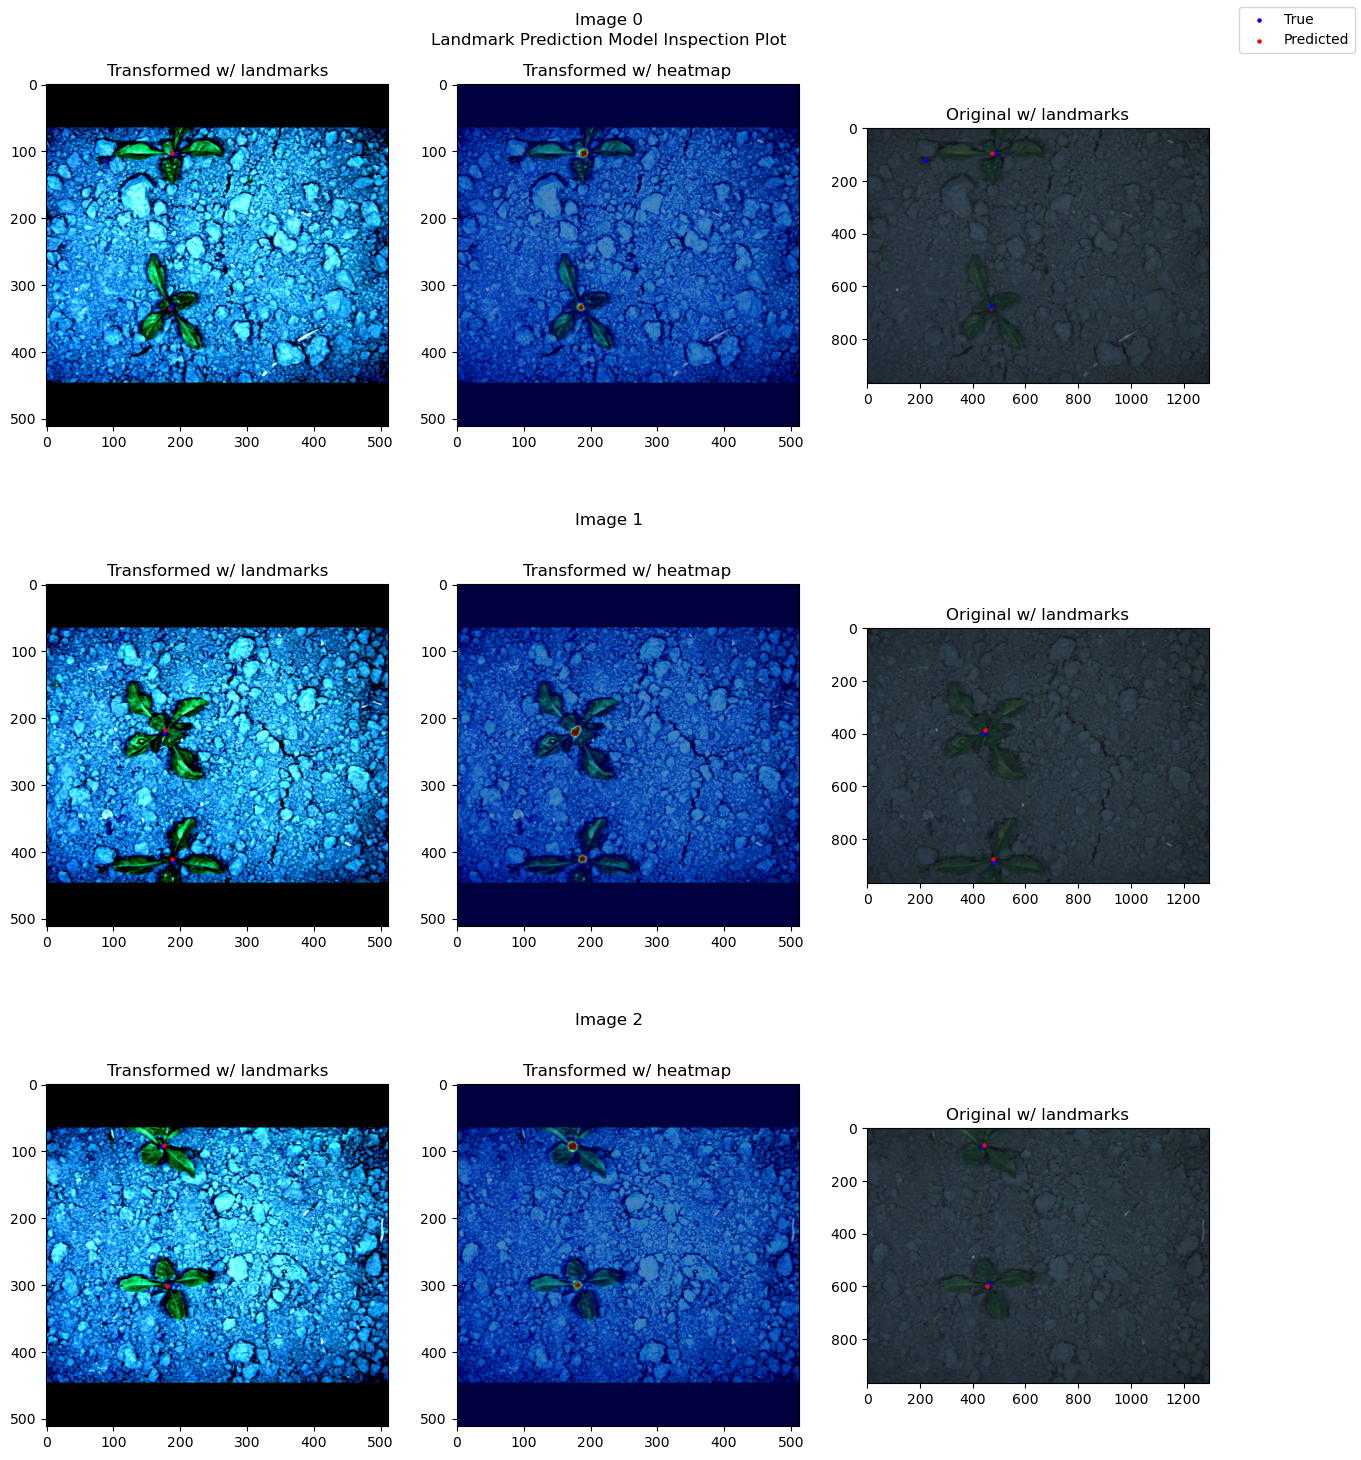

In [16]:
from landmarker.visualize.utils import prediction_inspect_plot_multi_instance
model.to("cpu")
prediction_inspect_plot_multi_instance(ds_test_A, model, range(3), threshold=threshold, activation=nn.Sigmoid())

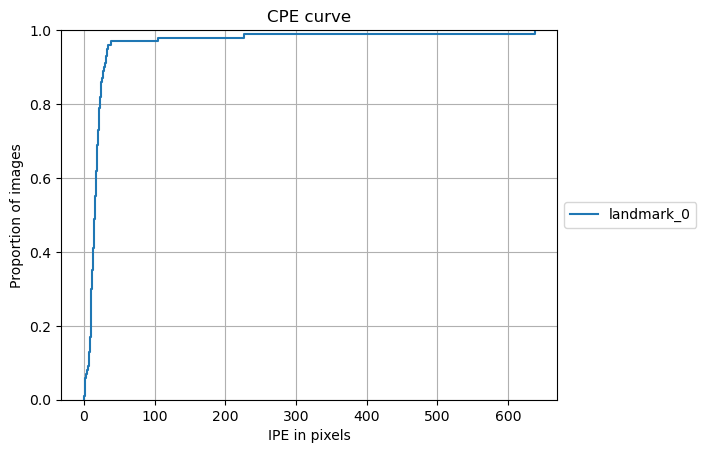

In [17]:
from landmarker.visualize import plot_cpe

plot_cpe(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0), dim=(512, 512),
            dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
            padding=torch.cat(paddings, axis=0), class_names=ds_test_A.class_names,
            group=False, title="CPE curve", save_path=None,
            stat='proportion', unit='pixels', kind='ecdf')

In [18]:
from landmarker.visualize.evaluation import multi_instance_detection_report

multi_instance_detection_report(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0),
                                torch.cat(tp, axis=0), torch.cat(fp, axis=0), torch.cat(fn, axis=0), dim=(512, 512),
                                dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
                                padding=torch.cat(paddings, axis=0), class_names=ds_test_A.class_names)

Detection report:
1# Instance detection statistics:
Class               TP        FP        FN        TPR       
------------------------------------------------------------
landmark_0          165.0     12.0      235.0     0.41      

2# Point-to-point error (PE) statistics:
Class               Mean      Median    Std       Min       Max       
----------------------------------------------------------------------
landmark_0          15.08     9.61      51.79     0.72      637.80    

3# Success detection rate (SDR):
Class               SDR (PE≤2mm)   SDR (PE≤2.5mm) SDR (PE≤3mm)   SDR (PE≤4mm)   
--------------------------------------------------------------------------------
landmark_0          1.50           2.50           4.50           6.00           
